# Nuclei Overview to Submission

In [1]:
import numpy as np
import pandas as pd
from glob import glob
import os
from skimage.io import imread
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
%matplotlib inline
dsb_data_dir = Path('C:/Users/sinjy/jupyter_notebook/datasets/kaggle_datasets/nuclei')
stage_label = Path('stage1')

C:\Users\sinjy\anaconda3\envs\machine-learning\lib\site-packages\skimage\io\manage_plugins.py:23: UserWarning: Your installed pillow version is < 8.1.2. Several security issues (CVE-2021-27921, CVE-2021-25290, CVE-2021-25291, CVE-2021-25293, and more) have been fixed in pillow 8.1.2 or higher. We recommend to upgrade this library.
  from .collection import imread_collection_wrapper


## Read in the labels

In [3]:
train_labels = pd.read_csv(dsb_data_dir / '{}_train_labels.csv'.format(stage_label))
train_labels['EncodedPixels'] = train_labels['EncodedPixels'].map(lambda ep: [int(x) for x in ep.split(' ')])
train_labels.sample(3)

,ImageId,EncodedPixels
17060,930f246a8e4ff273a72a6e4b3cf8e8caff94fca4eaf1db...,"[47649, 4, 47904, 6, 48159, 7, 48414, 9, 48669..."
10081,53ad09e4348767bece0165884bf40c10b72ae18444e3f4...,"[136892, 6, 137410, 9, 137929, 11, 138449, 12,..."
26761,e52960d31f8bddf85400259beb4521383f5ceface1080b...,"[331898, 8, 332417, 10, 332934, 14, 333451, 17..."


## Load in all Images

In [11]:
all_images = glob(str(dsb_data_dir / 'stage1_*' / '*' / '*' / '*'))
img_df = pd.DataFrame({'path': all_images})
img_id = lambda in_path: in_path.split('\\')[-3]
img_type = lambda in_path: in_path.split('\\')[-2]
img_group = lambda in_path: in_path.split('\\')[-4].split('_')[1]
img_stage = lambda in_path: in_path.split('\\')[-4].split('_')[0]
img_df['ImageId'] = img_df['path'].map(img_id)
img_df['ImageType'] = img_df['path'].map(img_type)
img_df['TrainingSplit'] = img_df['path'].map(img_group)
img_df['Stage'] = img_df['path'].map(img_stage)
img_df.sample(2)

,path,ImageId,ImageType,TrainingSplit,Stage
12752,C:\Users\sinjy\jupyter_notebook\datasets\kaggl...,62057502c387145ed4f8f7f0d5e5bedcb72d3bcec15fa7...,masks,train,stage1
15811,C:\Users\sinjy\jupyter_notebook\datasets\kaggl...,7f2b154541166210f468d89bb0a7184f10e51168a181db...,masks,train,stage1


## Create Training Data

In [35]:
%%time
train_df = img_df.query('TrainingSplit=="train"')
train_rows = []
group_cols = ['Stage', 'ImageId']
for n_group, n_rows in train_df.groupby(group_cols):
    c_row = {col_name: col_value for col_name, col_value in zip(group_cols, n_group)}
    c_row['masks'] = n_rows.query('ImageType == "masks"')['path'].values.tolist()
    c_row['images'] = n_rows.query('ImageType == "images"')['path'].values.tolist()
    train_rows += [c_row]
train_img_df = pd.DataFrame(train_rows)
IMG_CHANNELS = 3
def read_and_stack(in_img_list):
    return np.sum(np.stack([imread(c_img) for c_img in in_img_list], 0), 0) / 255.0
train_img_df['images'] = train_img_df['images'].map(read_and_stack).map(lambda x: x[:, :, :IMG_CHANNELS])
train_img_df['masks'] = train_img_df['masks'].map(read_and_stack).map(lambda x: x.astype(float))
train_img_df.sample(1)

Wall time: 1min 26s


,Stage,ImageId,masks,images
492,stage1,b909aa8f6f4bec37c3fb6ff5a85d166162d07983506fcc...,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[[0.7098039215686275, 0.6588235294117647, 0.8..."


## Show a few images

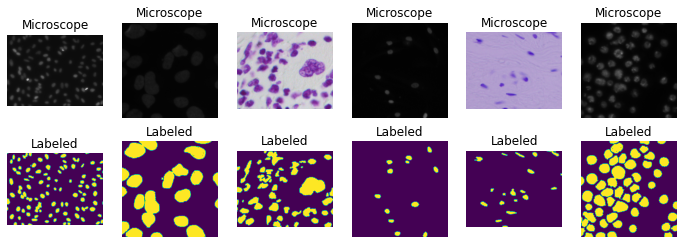

In [36]:
n_img = 6
fig, m_axs = plt.subplots(2, n_img, figsize=(12,4))
for (_, c_row), (c_im, c_lab) in zip(train_img_df.sample(n_img).iterrows(), m_axs.T):
    c_im.imshow(c_row['images'])
    c_im.axis('off')
    c_im.set_title('Microscope')
    
    c_lab.imshow(c_row['masks'])
    c_lab.axis('off')
    c_lab.set_title('Labeled')

## Look at the intensity distribution

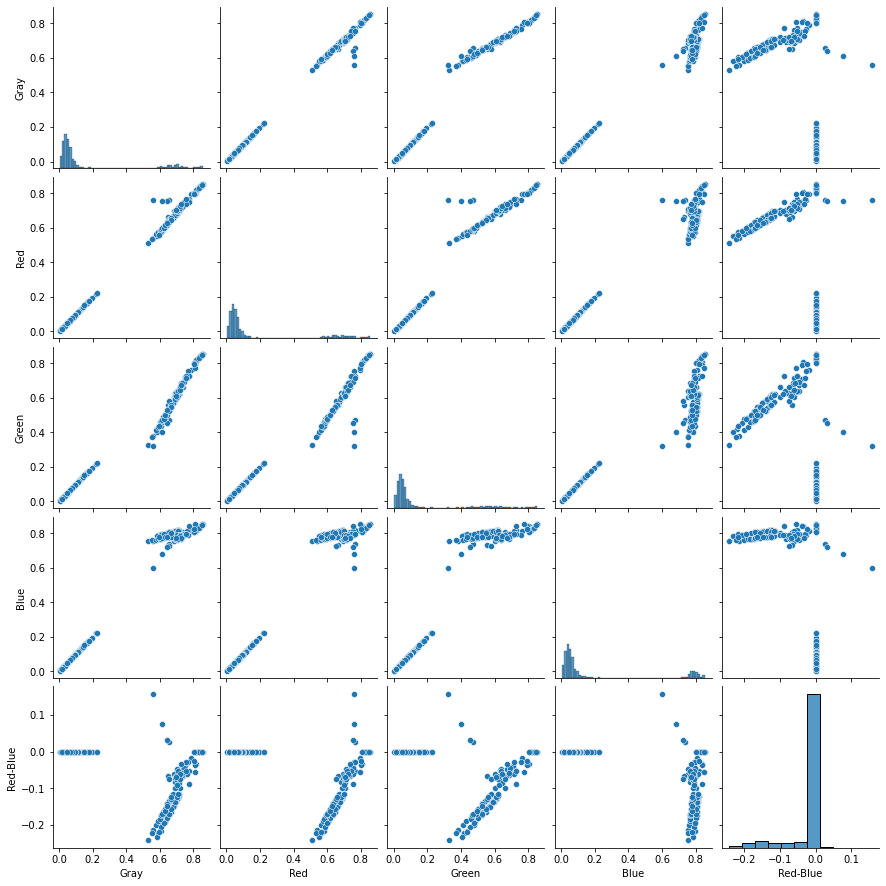

In [37]:
train_img_df['Red'] = train_img_df['images'].map(lambda x: np.mean(x[:, :, 0]))
train_img_df['Green'] = train_img_df['images'].map(lambda x: np.mean(x[:, :, 1]))
train_img_df['Blue'] = train_img_df['images'].map(lambda x: np.mean(x[:, :, 2]))
train_img_df['Gray'] = train_img_df['images'].map(lambda x: np.mean(x))
train_img_df['Red-Blue'] = train_img_df['images'].map(lambda x: np.mean(x[:, :, 0] - x[:, :, 2]))
sns.pairplot(train_img_df[['Gray', 'Red', 'Green', 'Blue', 'Red-Blue']])

## Check Dimensions

In [38]:
train_img_df['images'].map(lambda x: x.shape).value_counts()

(256, 256, 3)      334
(256, 320, 3)      112
(520, 696, 3)       92
(360, 360, 3)       91
(1024, 1024, 3)     16
(512, 640, 3)       13
(603, 1272, 3)       6
(260, 347, 3)        5
(1040, 1388, 3)      1
Name: images, dtype: int64

## Making a simple CNN

In [39]:
from keras.models import Sequential
from keras.layers import BatchNormalization, Conv2D, UpSampling2D, Lambda
simple_cnn = Sequential()
simple_cnn.add(BatchNormalization(input_shape=(None, None, IMG_CHANNELS), 
                                 name='NormalizeInput'))
simple_cnn.add(Conv2D(8, kernel_size=(3, 3), padding='same'))
simple_cnn.add(Conv2D(8, kernel_size=(3, 3), padding='same'))

simple_cnn.add(Conv2D(16, kernel_size=(3, 3), dilation_rate=2, padding='same'))
simple_cnn.add(Conv2D(16, kernel_size=(3, 3), dilation_rate=2, padding='same'))
simple_cnn.add(Conv2D(32, kernel_size=(3, 3), dilation_rate=3, padding='same'))

simple_cnn.add(Conv2D(16, kernel_size=(1, 1), padding='same'))
simple_cnn.add(Conv2D(1, kernel_size=(1, 1), padding='same', activation='sigmoid'))
simple_cnn.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
NormalizeInput (BatchNormali (None, None, None, 3)     12        
_________________________________________________________________
conv2d_13 (Conv2D)           (None, None, None, 8)     224       
_________________________________________________________________
conv2d_14 (Conv2D)           (None, None, None, 8)     584       
_________________________________________________________________
conv2d_15 (Conv2D)           (None, None, None, 16)    1168      
_________________________________________________________________
conv2d_16 (Conv2D)           (None, None, None, 16)    2320      
_________________________________________________________________
conv2d_17 (Conv2D)           (None, None, None, 32)    4640      
_________________________________________________________________
conv2d_18 (Conv2D)           (None, None, None, 16)   

## Loss

In [40]:
from keras import backend as K
smooth = 1.
def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)
def dice_coef_loss(y_true, y_pred):
    return -dice_coef(y_true, y_pred)
simple_cnn.compile(optimizer='adam', loss=dice_coef_loss, metrics = [dice_coef, 'acc', 'mse'])

## Simple Training

In [41]:
def simple_gen():
    while True:
        for _, c_row in train_img_df.iterrows():
            yield np.expand_dims(c_row['images'], 0), np.expand_dims(np.expand_dims(c_row['masks'], -1), 0)

simple_cnn.fit_generator(simple_gen(), steps_per_epoch=train_img_df.shape[0], 
                        epochs=3)

Epoch 1/3


C:\Users\sinjy\AppData\Roaming\Python\Python37\site-packages\keras\engine\training.py:1915: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


670/670 [==============================] - 237s 337ms/step - loss: -0.6238 - dice_coef: 0.6238 - acc: 0.7893 - mse: 0.1938
Epoch 2/3
670/670 [==============================] - 220s 329ms/step - loss: -0.7870 - dice_coef: 0.7870 - acc: 0.8788 - mse: 0.1112
Epoch 3/3
670/670 [==============================] - 228s 340ms/step - loss: -0.7916 - dice_coef: 0.7916 - acc: 0.8780 - mse: 0.1134


## Apply Model to Test

In [43]:
%%time
test_df = img_df.query('TrainingSplit=="test"')
test_rows = []
group_cols = ['Stage', 'ImageId']
for n_group, n_rows in test_df.groupby(group_cols):
    c_row = {col_name: col_value for col_name, col_value in zip(group_cols, n_group)}
    c_row['images'] = n_rows.query('ImageType == "images"')['path'].values.tolist()
    test_rows += [c_row]
test_img_df = pd.DataFrame(test_rows)

test_img_df['images'] = test_img_df['images'].map(read_and_stack).map(lambda x: x[:, :, :IMG_CHANNELS])
print(test_img_df.shape[0], 'images to process')
test_img_df.sample(1)

65 images to process
Wall time: 821 ms


,Stage,ImageId,images
57,stage1,dab46d798d29aff2e99c23f47ed3064f5cafb1644629b0...,"[[[0.01568627450980392, 0.01568627450980392, 0..."


In [44]:
%%time
test_img_df['masks'] = test_img_df['images'].map(lambda x: simple_cnn.predict(np.expand_dims(x, 0))[0, :, :, 0])

Wall time: 9.13 s


## Show a few predictions

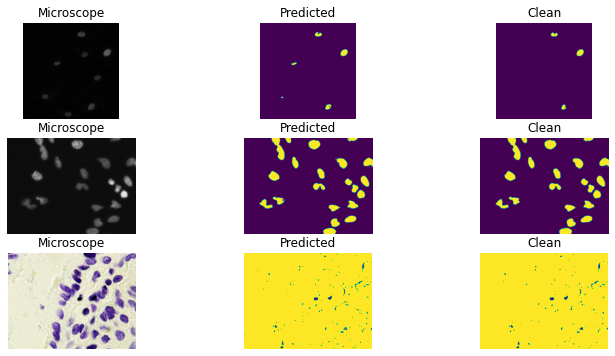

In [45]:
n_img = 3
from skimage.morphology import closing, opening, disk
def clean_img(x):
    return opening(closing(x, disk(1)), disk(3))
fig, m_axs = plt.subplots(3, n_img, figsize=(12, 6))
for (_, d_row), (c_im, c_lab, c_clean) in zip(test_img_df.sample(n_img).iterrows(), m_axs):
    c_im.imshow(d_row['images'])
    c_im.axis('off')
    c_im.set_title('Microscope')
    
    c_lab.imshow(d_row['masks'])
    c_lab.axis('off')
    c_lab.set_title('Predicted')
    
    c_clean.imshow(clean_img(d_row['masks']))
    c_clean.axis('off')
    c_clean.set_title('Clean')